In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_features = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
train_labels = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')
test_features = pd.read_csv('data/test_set_features.csv', index_col='respondent_id')

In [3]:
num_cols = train_features.select_dtypes('number').columns
num_cols

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object')

In [4]:
num_cols = train_features.select_dtypes("number").columns

cat_cols = [
    "race",
    "sex",
    "marital_status",
    "rent_or_own",
    "hhs_geo_region",
    "census_msa",
    "employment_industry",
    "employment_occupation",
]

ord_cols = ["age_group", "education", "income_poverty", "employment_status"]

assert len(num_cols) + len(cat_cols) + len(ord_cols) == train_features.shape[1]

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from category_encoders import OrdinalEncoder
import xgboost as xgb

In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
        ('ord', ordinal_transformer, ord_cols)
    ]
)

train_features_transformed = preprocessor.fit_transform(train_features)
test_features_transformed = preprocessor.fit_transform(test_features)

# Get feature names for transformed data
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols)
ord_feature_names = np.array(ord_cols)

# Combine all feature names into a single list
all_feature_names = np.concatenate((num_cols, cat_feature_names, ord_feature_names))

train_features = pd.DataFrame(train_features_transformed, columns=all_feature_names)
test_features = pd.DataFrame(test_features_transformed, columns=all_feature_names)

train_features

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,age_group,education,income_poverty,employment_status
0,0.50,0.333333,0.5,0.5,0.5,0.5,0.5,1.0,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1,1.00,1.000000,0.5,1.0,0.5,1.0,0.5,1.0,1.0,0.5,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,1.0,2.0
2,0.50,0.666667,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,3.0,2.0,2.0
3,0.50,0.666667,0.5,1.0,0.5,1.0,1.0,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,1.0,1.0
4,0.75,0.666667,0.5,1.0,0.5,1.0,1.0,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,0.75,0.333333,0.5,1.0,0.5,0.5,0.5,1.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,1.0
26703,0.50,1.000000,0.5,1.0,0.5,1.0,0.5,0.5,0.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,2.0
26704,0.75,1.000000,0.5,1.0,1.0,1.0,1.0,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0
26705,0.50,0.666667,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,2.0,2.0


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_features,
    train_labels,
    test_size=0.4,
    shuffle=True,
    random_state=314
)

X_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,age_group,education,income_poverty,employment_status
19046,0.25,1.000000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,2.0,2.0
12518,0.50,0.666667,0.5,1.0,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,4.0,2.0
17641,0.75,0.666667,0.5,1.0,0.5,1.0,1.0,1.0,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,1.0,3.0
10337,0.75,0.333333,0.5,1.0,0.5,1.0,0.5,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0
5775,0.50,0.666667,0.5,0.5,0.5,1.0,0.5,0.5,1.0,0.5,...,0.0,0.0,0.0,0.0,1.0,0.0,5.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11094,0.75,0.666667,0.5,1.0,0.5,1.0,0.5,0.5,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,2.0
10163,0.50,0.666667,0.5,0.5,0.5,1.0,0.5,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,2.0,1.0
11977,0.25,1.000000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0
9837,1.00,1.000000,1.0,1.0,0.5,1.0,0.5,0.5,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,3.0,2.0


In [15]:
from typing import Literal, Any, Dict
from dataclasses import dataclass
from catboost import CatBoostClassifier


@dataclass
class TrainResult:
    model: Any
    scores: np.ndarray
    probabilities: np.ndarray
    y_test_target: pd.DataFrame


def train_model(target: Literal['h1n1_vaccine', 'seasonal_vaccine'], model_type: Literal['xgboost', 'catboost']) -> TrainResult:
    y_train_target = y_train[[target]]
    y_test_target = y_test[[target]]
    
    if model_type == 'xgboost':
        model = get_xgboost()
    if model_type == 'catboost':
        model = get_catboost()

    # Fit the model on the entire training set
    model.fit(X_train, y_train_target)

    # Predict probabilities for the TEST set
    y_probabilities = model.predict_proba(X_test)[:, 1]

    # Predict scores for TEST set
    y_predictions = model.predict(X_test)
    
    return TrainResult(
        model=model,
        scores=y_predictions,
        probabilities=y_probabilities,
        y_test_target=y_test_target
    )    
    
def get_xgboost():
    return xgb.XGBClassifier(
        colsample_bytree=0.6, 
        learning_rate=0.01,
        max_depth=5,
        n_estimators=1000,
        subsample=0.3
    )

def get_catboost():
    return CatBoostClassifier(
        n_estimators=1000,
        max_depth=5,
        logging_level='Silent'
    )

In [9]:
def get_test_probabilities(model: Any) -> np.ndarray:
    return model.predict_proba(test_features)[:, 1]

In [10]:
from sklearn.metrics import roc_curve, auc


def process_result(result_h1n1: TrainResult, result_seasonal: TrainResult, model_type: Literal['xgboost', 'catboost'], axe: Any):
    fpr_h1n1, tpr_h1n1, _ = roc_curve(result_h1n1.y_test_target, result_h1n1.probabilities)
    fpr_seasonal, tpr_seasonal, _ = roc_curve(result_seasonal.y_test_target, result_seasonal.probabilities)
    
    roc_auc_h1n1 = auc(fpr_h1n1, tpr_h1n1)
    roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)

    axe.plot(fpr_h1n1, tpr_h1n1, color='blue', label=f'H1N1 (AUC = {roc_auc_h1n1:.4f})')
    axe.plot(fpr_seasonal, tpr_seasonal, color='red', label=f'Seasonal (AUC = {roc_auc_seasonal:.4f})')
    axe.plot([0, 1], [0, 1], color='gray', linestyle='--')
    axe.set_xlabel('False Positive Rate')
    axe.set_ylabel('True Positive Rate')
    axe.set_title(f'ROC Curve for {model_type}')
    axe.legend(loc='lower right')
    axe.grid(True)
    
    return np.average([roc_auc_h1n1, roc_auc_seasonal])

In [11]:
def process_model(model_type: Literal['xgboost', 'catboost'], axe: Any) -> Any:
    result_h1n1 = train_model(
        target='h1n1_vaccine',
        model_type=model_type
    )
    result_seasonal = train_model(
        target='seasonal_vaccine',
        model_type=model_type
    )
    roc_auc = process_result(result_h1n1, result_seasonal, model_type, axe)
    
    print(f'Mean ROC AUC ({model_type}) = {roc_auc:.4f}')
    
    return {
        'h1n1_vaccine': result_h1n1.model,
        'seasonal_vaccine': result_seasonal.model
    }

Mean ROC AUC (xgboost) = 0.8650
Mean ROC AUC (catboost) = 0.8629


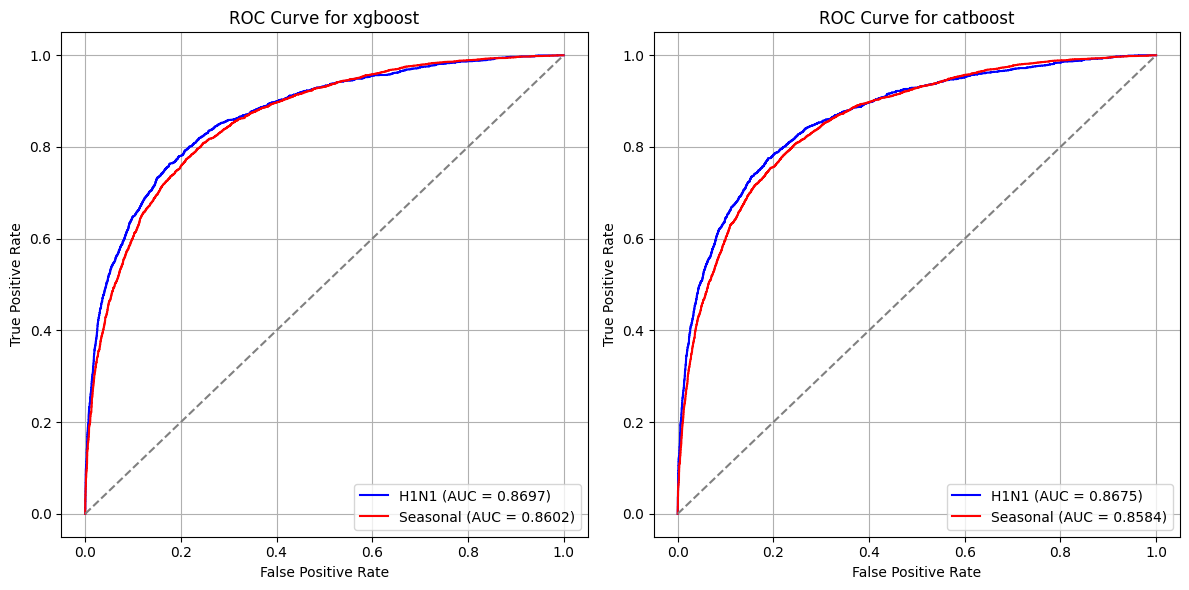

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

models_xgboost = process_model('xgboost', axes[0])
models_catboost = process_model('catboost', axes[1])

plt.tight_layout()
plt.show()

In [15]:
# from datetime import datetime


# submission = pd.read_csv('data/submission_format.csv')

# models = process_model('xgboost')

# submission['h1n1_vaccine'] = get_test_probabilities(result_h1n1.model)
# submission['seasonal_vaccine'] = get_test_probabilities(result_seasonal.model)

# submission.to_csv(f'submission/submission_{datetime.now().isoformat(sep='_')}.csv', index=False)

# submission

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.171270,0.349341
1,26708,0.021499,0.045364
2,26709,0.162811,0.352967
3,26710,0.515226,0.869933
4,26711,0.390040,0.538098
...,...,...,...
26703,53410,0.252479,0.597809
26704,53411,0.183881,0.282557
26705,53412,0.175007,0.274644
26706,53413,0.025884,0.225328
